# Experiments

Graph Neural Index method.

In [1]:
# !pip install -q geopandas
# !pip install -q -U --pre h3
# !pip install -q scikit-learn
# !pip install -q torch==1.13.1+cu116 -f https://download.pytorch.org/whl/torch_stable.html

In [2]:
import pathlib, sys
sys.path.insert(1, str(pathlib.Path().resolve().parents[0]))

In [3]:
import datetime
import warnings
from itertools import chain
from typing import Optional

import altair as alt
import numpy as np
import pandas as pd
from dateutil.relativedelta import relativedelta
from sklearn.metrics import (
    mean_absolute_error,
    mean_absolute_percentage_error,
    median_absolute_error,
    r2_score,
)

from hpipy.extensions.neural.neural_avm.data_pipeline import DataPipeline
from hpipy.extensions.neural.neural_avm.data_preprocessors import (
    GeospatialPreprocessor,
    TemporalPreprocessor,
)
from hpipy.extensions.neural.neural_avm.data_transformers import (
    FeatureTransformer,
    ResponseTransformer,
)
from hpipy.extensions.neural.neural_avm.model_gnn import GraphNeuralAVM

alt.data_transformers.enable("default", max_rows=25_000)
alt.renderers.enable("mimetype")
np.random.seed(0)
pd.options.display.max_columns = None
warnings.simplefilter(action="ignore", category=FutureWarning)

In [4]:
df = pd.read_csv('../data/kingcountysales.csv', index_col=0, parse_dates=['sale_date'])

## Data Understanding

In [5]:
df.head()

,sale_id,pinx,sale_date,sale_price,sale_nbr,sale_warning,join_status,join_year,latitude,longitude,area,city,zoning,subdivision,present_use,land_val,imp_val,year_built,year_reno,sqft_lot,sqft,sqft_1,sqft_fbsmt,grade,fbsmt_grade,condition,stories,beds,bath_full,bath_3qtr,bath_half,garb_sqft,gara_sqft,wfnt,golf,greenbelt,noise_traffic,view_rainier,view_olympics,view_cascades,view_territorial,view_skyline,view_sound,view_lakewash,view_lakesamm,view_otherwater,view_other,submarket
1,1999..144,..2734100475,1999-01-05,150000,1,,demo,1999,47.544359,-122.320786,78,SEATTLE,SF 5000,GEORGETOWN,2,21000,66000,1900,0,4000,1410,760,0,7,0,3,1.5,3,1,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,E
2,1999..258,..1535200725,1999-01-05,235000,1,,demo,1999,47.421247,-122.438139,100,KING COUNTY,RA2.5P,CHAUTAUQUA BEACH ADD,2,46000,132000,1916,0,6695,990,990,0,6,0,4,1.0,2,1,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,H
3,1999..331,..6028000255,1999-01-04,293000,1,,demo,1999,47.572103,-122.122257,31,KING COUNTY,R6,NELSONS H E EASTWAY PARK,2,66000,207000,1986,0,12360,2020,1470,0,8,0,3,2.0,3,1,1,1,0,480,0,0,0,2,0,0,0,0,0,0,0,0,0,0,R
4,1999..660,..6145600690,1999-01-08,164000,1,,demo,1999,47.703824,-122.347166,5,SEATTLE,SF 5000,NORTH PARK ADD,2,66000,85000,1922,0,3844,1100,910,190,6,5,3,1.0,2,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,B
5,1999..775,..1939800005,1999-01-07,270000,1,,demo,1999,47.764482,-122.208069,38,BOTHELL,R15 OP,DEGNEAUS HALF-ACRE TRS,2,73000,119000,1924,0,13600,2050,1300,0,7,0,5,1.5,5,1,0,1,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,Q


In [6]:
df.tail()

,sale_id,pinx,sale_date,sale_price,sale_nbr,sale_warning,join_status,join_year,latitude,longitude,area,city,zoning,subdivision,present_use,land_val,imp_val,year_built,year_reno,sqft_lot,sqft,sqft_1,sqft_fbsmt,grade,fbsmt_grade,condition,stories,beds,bath_full,bath_3qtr,bath_half,garb_sqft,gara_sqft,wfnt,golf,greenbelt,noise_traffic,view_rainier,view_olympics,view_cascades,view_territorial,view_skyline,view_sound,view_lakewash,view_lakesamm,view_otherwater,view_other,submarket
560215,2022..35230,..1337800060,2022-12-17,1750000,3,,reno - before,2022,47.629275,-122.307670,13,SEATTLE,NR3,CAPITOL HILL ADD DIV NO. 04,2,853000,727000,1908,2000,4800,2900,1080,1050,9,8,3,1.5,4,1,1,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,D
560216,2022..35574,..2856100991,2022-12-15,1250000,3,,reno - before,2022,47.676524,-122.392174,19,SEATTLE,NR3,GRAFFS SALMON BAY ADD TO BALLARD,2,497000,532000,1928,2007,3825,1730,1030,700,8,8,3,1.0,3,1,1,0,180,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,B
560217,2022..35591,..4430100010,2022-12-16,1268900,1,,reno - before,2022,47.713828,-122.361862,39,SEATTLE,NR2,LOVELLS ELLSWORTH REPLAT POR TR 12,2,359000,637000,1951,2002,7200,3050,1420,0,8,0,3,3.0,4,2,1,1,0,400,0,0,0,0,0,0,0,0,0,0,0,0,0,0,B
560218,2022..35644,..9253900030,2022-12-14,2300000,2,,reno - before,2022,47.601373,-122.112468,47,BELLEVUE,R-3.5,WEOWNA BEACH,2,742000,1432000,1983,2006,7945,3400,1560,1290,9,8,3,2.0,4,2,1,1,0,460,0,0,0,0,0,0,3,4,0,0,0,3,0,0,R
560219,2022..35645,..9253900030,2022-12-16,2300000,3,,reno - before,2022,47.601373,-122.112468,47,BELLEVUE,R-3.5,WEOWNA BEACH,2,742000,1432000,1983,2006,7945,3400,1560,1290,9,8,3,2.0,4,2,1,1,0,460,0,0,0,0,0,0,3,4,0,0,0,3,0,0,R


In [7]:
df.shape

(560219, 48)

We can see that the each sale is associated with a `sale_date`, which is in YYYY-MM-DD format. We can break this single column into the year, month, day, and even week of the year that the sale occurred.

In [8]:
df["sale_date"] = pd.to_datetime(df["sale_date"])

df["sale_date_yyyymm"] = df["sale_date"].astype(str).str[:-3].str.replace("-", "")
df["sale_decade"] = df["sale_date"].apply(lambda x: "{}'s".format(x.year - (x.year % 10)))
df["sale_year"] = df["sale_date"].dt.year
df["sale_month"] = df["sale_date"].dt.month
df["sale_week"] = df["sale_date"].dt.isocalendar().week
df["sale_day"] = df["sale_date"].dt.day

We divide our training and testing data so that the test data is comprised solely of sales that take place after the sales in the training data, such that we predict future sale prices based on past, historical sale prices.

In [9]:
max_train_date = "2022-12-31"
min_train_date = "2000-01-01"

df_train = df[(df["sale_date"] < max_train_date) & (df["sale_date"] >= min_train_date)].copy()
df_test = df[df["sale_date"] >= max_train_date].copy()

df_train = df_train.sort_values(['sale_date', 'pinx', 'sale_id'])

df_train.shape, df_test.shape

((535724, 54), (0, 54))

## Data Preprocessing

We can first organize the columns into groups of features.

In [10]:
feature_dict = {
    "numerics": [
        "latitude",
        "longitude",
    ],
    "log_numerics": [
        "sqft_lot",
        "sqft",
    ],
    "categoricals": [
        # "zipcode",
        # "city",
        "join_status",
        "area",
        "present_use",
        "wfnt",
        "sale_date",
    ],
    "ordinals": [
        "year_built",
        "year_reno",
        "grade",
        "stories",
        "beds",
        "bath_full",
        "bath_3qtr",
        "bath_half",
    ],
    "hpi": [
        # "zipcode",
        # "city",
        "sale_date",
    ]
}

id_cols = ["sale_id", "pinx", "submarket"]
response_col = "sale_price"
feature_cols = list(set(chain(*feature_dict.values())))

## Evaluation Metrics

We define several evaluation metrics that can be used to evaluate candidate models.

In [11]:
def mean_percentage_error(true: np.ndarray, pred: np.ndarray, epsilon: float = 1e-6) -> float:
    """Mean Percentage Error (MPE)."""
    pe = (pred - true) / (true + epsilon)
    return np.mean(pe)


def median_absolute_percentage_error(
    true: np.ndarray,
    pred: np.ndarray,
    epsilon: float = 1e-6,
) -> float:
    """Median Absolute Percentage Error (MdAPE)."""
    ape = np.abs(pred - true) / (true + epsilon)
    return np.median(ape)


def median_percentage_error(true: np.ndarray, pred: np.ndarray, epsilon: float = 1e-6) -> float:
    """Median Percentage Error (MdPE)."""
    pe = (pred - true) / (true + epsilon)
    return np.median(pe)


def frac_within_ci(true: np.ndarray, pred_low: np.ndarray, pred_high: np.ndarray) -> float:
    """Fraction within Confidence Interval."""
    wci = (true >= pred_low) & (true <= pred_high)
    return np.mean(wci)


def mean_ci_width(
    true: np.ndarray,
    pred_low: np.ndarray,
    pred_high: np.ndarray,
    epsilon: float = 1e-6,
) -> float:
    """Mean Confidence Interval Width."""
    ciw = (pred_high - pred_low) / (true + epsilon)
    return np.mean(ciw)


def median_ci_width(
    true: np.ndarray,
    pred_low: np.ndarray,
    pred_high: np.ndarray,
    epsilon: float = 1e-6,
) -> float:
    """Median Confidence Interval Width."""
    ciw = (pred_high - pred_low) / (true + epsilon)
    return np.median(ciw)


def evaluate_preds(
    y_test: np.ndarray,
    y_pred: np.ndarray,
    y_pred_low: Optional[np.ndarray] = None,
    y_pred_high: Optional[np.ndarray] = None,
) -> dict[str, float]:
    output = {}
    output["Count"] = len(y_test)
    output["R2"] = r2_score(y_test, y_pred)
    output["MAE"] = mean_absolute_error(y_test, y_pred)
    output["MdAE"] = median_absolute_error(y_test, y_pred)
    output["MPE"] = mean_percentage_error(y_test, y_pred)
    output["MdPE"] = median_percentage_error(y_test, y_pred)
    output["MAPE"] = mean_absolute_percentage_error(y_test, y_pred)
    output["MdAPE"] = median_absolute_percentage_error(y_test, y_pred)
    if y_pred_low is not None and y_pred_high is not None:
        output["Pct. Within CI"] = frac_within_ci(y_test, y_pred_low, y_pred_high)
        output["Mean CI Width"] = mean_ci_width(y_test, y_pred_low, y_pred_high)
        output["Med. CI Width"] = median_ci_width(y_test, y_pred_low, y_pred_high)
    return output

## Model Construction and Training

In [12]:
num_models = 1
num_epochs = 20
batch_size = 1024
k = 10
num_neighbors = [5, 5]
conv_dims = [32, 32]
dense_dims = [32]
emb_size = 5
use_edge_features = False
mha_heads = 4
dropout_rate = 0.1
learning_rate= 1e-3
geo_resolutions = [6, 7]
min_pred_epoch = 16
quantiles = [0.25, 0.5, 0.75]

In [13]:
feature_preprocessors = [
    GeospatialPreprocessor(
        resolutions=geo_resolutions,
        latitude_col="latitude",
        longitude_col="longitude",
    ),
    TemporalPreprocessor(
        min_train_date,
        max_train_date,
        saledate_col="sale_date",
    ),
]

feature_transformer = FeatureTransformer(feature_dict)
response_transformer = ResponseTransformer()

data_pipeline = DataPipeline(
    feature_dict,
    response_col,
    feature_preprocessors=feature_preprocessors,
    feature_transformer=feature_transformer,
    response_transformer=response_transformer,
)

In [14]:
X_train, y_train = data_pipeline.train_transform(df_train)

feature_dict_trans = data_pipeline.get_transformed_feature_dict()
init_dict = feature_transformer.prepare_init_dict(X_train)

In [15]:
model = GraphNeuralAVM(
    num_models,
    init_dict,
    feature_dict_trans,
    conv_dims=conv_dims,
    dense_dims=dense_dims,
    emb_size=emb_size,
    use_edge_features=use_edge_features,
    mha_heads=mha_heads,
    dropout_rate=dropout_rate,
    learning_rate=learning_rate,
)

Number of Parameters: 58986
BaseGraphNeuralAVM(
  (x_emb): ModuleDict(
    (area): Embedding(96, 5)
    (bath_3qtr): OrdinalEmbedding(11, 5)
    (bath_full): OrdinalEmbedding(10, 5)
    (bath_half): OrdinalEmbedding(9, 5)
    (beds): OrdinalEmbedding(18, 5)
    (grade): OrdinalEmbedding(14, 5)
    (join_status): Embedding(9, 5)
    (lat_lng_h3_6): Embedding(121, 5)
    (lat_lng_h3_7): Embedding(618, 5)
    (present_use): Embedding(4, 5)
    (stories): OrdinalEmbedding(9, 5)
    (weekssincestartdate): OrdinalEmbedding(1195, 5)
    (wfnt): Embedding(10, 5)
    (year_built): OrdinalEmbedding(123, 5)
    (year_reno): OrdinalEmbedding(94, 5)
  )
  (convs_prp): ModuleList(
    (0): Dropout(p=0.1, inplace=False)
    (1): TransformerConv(79, 32, heads=4)
    (2): TransformerConv(32, 32, heads=1)
  )
  (convs_hpi): ModuleList(
    (0): TransformerConv(7, 32, heads=4)
    (1): TransformerConv(32, 32, heads=1)
  )
  (dense_prp): Sequential(
    (0): Linear(in_features=32, out_features=32, bias=Tr

In [16]:
model.fit(
    X_train,
    y_train,
    num_epochs=num_epochs,
    batch_size=batch_size,
    dataloader_kwargs={
        "k": k,
        "num_neighbors": num_neighbors,
        "sale_date": df_train["sale_date"],
        "latitude": df_train["latitude"],
        "longitude": df_train["longitude"],
    },
)

Training model 1...
Epoch 1/20 - 128s - loss: 0.08775
Epoch 2/20 - 126s - loss: 0.06942
Epoch 3/20 - 125s - loss: 0.06592
Epoch 4/20 - 124s - loss: 0.06464
Epoch 5/20 - 126s - loss: 0.06343
Epoch 6/20 - 130s - loss: 0.06278
Epoch 7/20 - 132s - loss: 0.06242
Epoch 8/20 - 132s - loss: 0.06189
Epoch 9/20 - 131s - loss: 0.06169
Epoch 10/20 - 130s - loss: 0.06126
Epoch 11/20 - 135s - loss: 0.06110
Epoch 12/20 - 139s - loss: 0.06087
Epoch 13/20 - 157s - loss: 0.06092
Epoch 14/20 - 158s - loss: 0.06050
Epoch 15/20 - 205s - loss: 0.06042
Epoch 16/20 - 212s - loss: 0.06032
Epoch 17/20 - 224s - loss: 0.06011
Epoch 18/20 - 241s - loss: 0.06014
Epoch 19/20 - 235s - loss: 0.06009
Epoch 20/20 - 203s - loss: 0.05988


## Model Evaluation

In [17]:
# df_predict = df_test
df_predict = df_train.iloc[-5000:]

X_test, y_test = data_pipeline.predict_transform(
    df_predict,
    max_train_date=max_train_date,
    # override_date=True,
    override_date=False,
    return_y=True,
)

In [18]:
y_pred, _ = model.predict(
    X_test,
    quantiles=quantiles,
    min_epoch=min_pred_epoch,
    dataloader_kwargs={
        "k": k,
        "sale_date": df_predict["sale_date"],
        "latitude": df_predict["latitude"],
        "longitude": df_predict["longitude"],
    },
)

y_true = response_transformer.inverse_transform(y_test)
y_pred = response_transformer.inverse_transform(y_pred)[-len(X_test):, :]

In [19]:
y_pred = [np.array(x) for x in list(zip(*y_pred.tolist()))]
results = pd.DataFrame([evaluate_preds(y_true, *y_pred)], index=["Neural Net"])
results

,Count,R2,MAE,MdAE,MPE,MdPE,MAPE,MdAPE,Pct. Within CI,Mean CI Width,Med. CI Width
Neural Net,5000,0.707093,182822.135163,98874.5625,-0.067695,-0.092126,0.15142,0.121466,0.283,0.138997,0.135355


## Evaluate the Generated Index

In [20]:
def read_cs(seasonally_adjusted=False, return_diff=False):
    name = "SEXRSA" if seasonally_adjusted else "SEXRNSA"
    try:
        df_sexrsa = pd.read_csv(f"../data/{name}.csv")
    except FileNotFoundError:
        # Fetch S&P/Case-Shiller WA-Seattle Home Price Index from FRED.
        print("Fetching S&P/Case-Shiller WA-Seattle Home Price Index from FRED...")
        path = f"https://fred.stlouisfed.org/graph/fredgraph.csv?id={name}"
        df_sexrsa = pd.read_csv(path)

    # df_sexrsa = df_sexrsa[df_sexrsa["DATE"] >= "2000-01-01"].reset_index(drop=True)
    df_sexrsa = df_sexrsa[df_sexrsa["DATE"] >= min_train_date].reset_index(drop=True)
    df_xrsa = pd.concat([df_sexrsa], axis=1)
    df_xrsa["month"] = pd.to_datetime(df_xrsa["DATE"], format="%Y-%m-%d")
    df_xrsa = df_xrsa.drop("DATE", axis=1)
    df_xrsa = pd.melt(df_xrsa, id_vars=["month"], value_vars=[name], var_name="index")
    df_xrsa["value"] = df_xrsa["value"] / 100.
    df_xrsa["Index"] = "Case-Shiller"

    df_xrsa = df_xrsa[df_xrsa["month"] >= "2000-01-01"].reset_index(drop=True)
    # df_xrsa = df_xrsa[df_xrsa["month"] < "2023-01-01"].reset_index(drop=True)


    def county_xrsa_index(x):
        x = x.reset_index(drop=True)
        x["value"] = x["value"] * (1. / x["value"][0])
        return x[["Index", "index", "month", "value"]]


    def county_xrsa_index_diff(x):
        x = county_xrsa_index(x)
        x["value"] = x["value"].diff()
        return x[["Index", "index", "month", "value"]]


    df_xrsa = (
        df_xrsa
        .groupby(["index"])
        .apply(lambda x: county_xrsa_index(x))
        .reset_index(drop=True)
    )
    df_xrsa_diff = (
        df_xrsa
        .groupby(["index"])
        .apply(lambda x: county_xrsa_index_diff(x))
        .reset_index(drop=True)
    )

    return (df_xrsa, df_xrsa_diff) if return_diff else df_xrsa

In [21]:
def read_fhfa(seasonally_adjusted=False, return_diff=False):
    # df = pd.read_excel("data/HPI_PO_metro.xls")
    df = pd.read_csv("../data/HPI_AT_metro.csv")
    df.columns = ["metro_name", "cbsa", "yr", "qtr", "index_nsa", "index_diff"]
    df = df[df["cbsa"] == 42644]
    df = df[df["yr"] >= datetime.datetime.strptime(min_train_date, "%Y-%m-%d").year]
    df = df.reset_index(drop=True)
    df["value"] = df["index_nsa"]
    df["period"] = df["yr"].astype(str) + "-Q" + df["qtr"].astype(str)
    df["month"] = pd.PeriodIndex(df["period"], freq='Q').to_timestamp()
    df = df[["month", "value"]]
    df["value"] = df["value"].str.strip().astype(float) / 100.
    df["Index"] = "FHFA"
    df["index"] = "SEA"
    df = df[df["month"] >= "2000-01-01"].reset_index(drop=True)
    # df = df[df["month"] < "2023-01-01"].reset_index(drop=True)
    df["value"] = df["value"] * (1. / df.loc[0, "value"])


    def county_index(x):
        x = x.reset_index(drop=True)
        x["value"] = x["value"] * (1. / x["value"][0])
        return x[["Index", "index", "month", "value"]]


    def county_index_diff(x):
        x = county_index(x)
        x["value"] = x["value"].diff()
        return x[["Index", "index", "month", "value"]]


    df = (
        df
        .groupby(["index"])
        .apply(lambda x: county_index(x))
        .reset_index(drop=True)
    )
    df_diff = (
        df
        .groupby(["index"])
        .apply(lambda x: county_index_diff(x))
        .reset_index(drop=True)
    )

    return (df, df_diff) if return_diff else df

In [22]:
def get_nz_index(model, df, region=None, seasonally_adjusted=False, max_year=None):
    df = df.copy()

    if max_year is None:
        max_year = pd.to_datetime(max_train_date).year + 1

    n_years = max_year - pd.to_datetime(min_train_date).year
    n_forecast_months = 0

    dfs = []
    for j in range(52 * n_years + 1 + n_forecast_months):
        df_i = df.iloc[:1, :].copy()
        if region is None:
            df_i["city"] = np.nan
        else:
            df_i["city"] = region
        df_i["sale_date"] = (
            pd.to_datetime(min_train_date) + relativedelta(weeks=+j)
        ).strftime("%Y-%m-%d")
        dfs.append(df_i)
    df = pd.concat(dfs)

    yyymm = df["sale_date"].astype(str).str[:-3].str.replace("-", "").values

    X_test, y_test = data_pipeline.predict_transform(df, override_date=False, return_y=True)
    X_test[list(set(X_test.columns).difference(["weekssincestartdate", "weekofyearsin", "weekofyearcos"]))] = 0

    if seasonally_adjusted:
        X_test["weekofyearsin"] = 0
        X_test["weekofyearcos"] = 0

    df["sale_date"] = pd.to_datetime(df["sale_date"], format="%Y-%m-%d")
    dataloader_kwargs = {
        "k": k,
        "sale_date": df["sale_date"],
        "latitude": df["latitude"],
        "longitude": df["longitude"],
    }
    _, X2 = model.predict(
        X_test,
        quantiles=quantiles,
        # quantiles=[0.05, 0.5, 0.95],
        min_epoch=min_pred_epoch,
        max_epoch=None,
        dataloader_kwargs=dataloader_kwargs,
    )
    X2 = X2[-len(X_test):, :]
    # X_baseline = data_pipeline.predict_transform(df.iloc[:1, :], override_date=False, return_y=False)
    # X_baseline[list(set(X_baseline.columns).difference(["weekssincestartdate", "weekofyearsin", "weekofyearcos"]))] = 0
    # df_attrs = model.explain(X_test, X_baseline, quantile=0.5, min_epoch=min_pred_epoch, dataloader_kwargs=dataloader_kwargs)
    # X2 = np.tile(df_attrs[["weekssincestartdate", "weekofyearsin", "weekofyearcos"]].sum(axis=1).values.reshape(-1, 1), (1, 3))

    df_index = pd.DataFrame(np.exp(X2))
    df_index["month"] = yyymm
    df_index = df_index.groupby("month").mean()
    
    base_index = df_index[1][0]
    for c in range(3):
        df_index[c] = df_index[c] * (1. / base_index)

    df_index["value_low"] = df_index[[0, 1, 2]].min(axis=1)
    df_index["value_high"] = df_index[[0, 1, 2]].max(axis=1)
    df_index["value"] = df_index[[1]]
    df_index["value_low"] = df_index["value"] - df_index["value_low"]
    df_index["value_high"] = df_index["value_high"] - df_index["value"]
    df_index = df_index.drop(columns=[0, 1, 2])
    df_index["month"] = np.arange(len(df_index))
    df_index["month"] = df_index["month"].apply(
        lambda x: (pd.to_datetime(min_train_date) + relativedelta(months=+x)).strftime("%Y-%m-%d")
    )
    df_index["index"] = "Neural"

    return df_index

In [23]:
def plot_index(df, region=None, height=None, width=None, max_plot_date=None):
    source = df.copy()

    source["month"] = pd.to_datetime(source["month"], format="%Y-%m-%d").dt.to_period("M").dt.to_timestamp("M")

    if max_plot_date is not None:
        source = source[source["month"] < pd.to_datetime(max_plot_date)]

    if region is not None:
        source = source[source["index"] != "Case-Shiller"]
        source["index"] = source[region]
        index_title = region
        index_sort = list(source[region].value_counts().index)
    else:
        index_title = "Method"
        index_sort = sorted(source["index"].unique())

    lines = alt.Chart(source).mark_line().encode(
        x=alt.X("month:T", axis=alt.Axis(format="%Y", labelAngle=0, title="Date")),
        y=alt.Y("value:Q", title="Index"),
        color=alt.Color("index:N", sort=index_sort),
        tooltip=[
            alt.Tooltip("month:T", format="%b %Y", title="Date"),
            alt.Tooltip("index:N", title=index_title),
            alt.Tooltip("value_low:Q", format=".3f", title="Value (Low)"),
            alt.Tooltip("value:Q", format=".3f", title="Value"),
            alt.Tooltip("value_high:Q", format=".3f", title="Value (High)"),
        ],
    )
    if height is not None:
        lines = lines.properties(height=height)
    if width is not None:
        lines = lines.properties(width=width)

    errorbars = lines.mark_errorband(opacity=0.33).encode(
        x=alt.X("month:T", axis=alt.Axis(format="%Y", labelAngle=0, title="Date")),
        y=alt.Y("value_low:Q", title=""),
        y2=alt.Y2("value_high:Q", title=""),
        color=alt.Color("index:N", title=index_title, sort=index_sort),
    )

    if max_plot_date is not None:
        df_cutoff = pd.DataFrame({
            "start": [pd.to_datetime(max_train_date)],
            "stop": [pd.to_datetime(max_plot_date)],
        })

        cutoff = alt.Chart(df_cutoff).mark_rect(
            opacity=0.2,
            color="red",
        ).encode(
            x=alt.X("start:T"),
            x2=alt.X2("stop:T"),
            y=alt.value(0),
            y2=alt.value(300),
        )


    if region is None:
        chart1 = lines + errorbars
    else:
        chart1 = lines

    if max_plot_date is not None:
        chart1 = chart1 + cutoff

    chart1 = chart1.interactive()

    # Month-over-month difference.
    source_diff = source.copy()
    for index in source_diff["index"].unique():
        cols = ["value_low", "value", "value_high"]
        for col in cols:
            idx = source["index"] == index
            source_diff.loc[idx, col] = source_diff.loc[idx, col].diff()

    lines_diff = lines.encode(
        y=alt.Y("value:Q", title="Index Diff")
    ).properties(
        data=source_diff,
    )
    errorbars_diff = lines_diff.mark_errorband(opacity=0.2).encode(
        x=alt.X("month:T", axis=alt.Axis(format="%Y", labelAngle=0, title="Date")),
        y=alt.Y("value_low:Q", title=""),
        y2=alt.Y2("value_high:Q", title=""),
        color=alt.Color("index:N", title=index_title, sort=index_sort),
    )

    if region is None:
        chart2 = lines_diff + errorbars_diff
    else:
        chart2 = lines_diff

    if max_plot_date is not None:
        chart2 = chart2 + cutoff

    chart2 = chart2.interactive()

    return chart1 & chart2

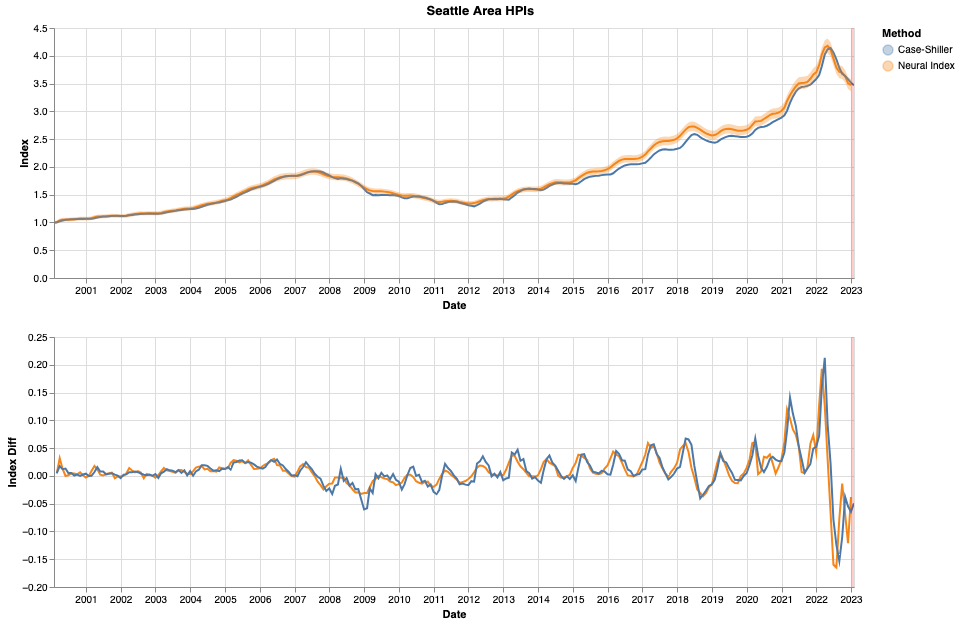

In [24]:
def plot_seattle_index(df, max_plot_date=None):
    if max_plot_date is None:
        max_plot_date = df["sale_date"].max().strftime("%Y-%m-%d")

    df_cs = (
        read_cs(seasonally_adjusted=False)
        .drop(columns="Index")
        .assign(value_low=lambda x: 0)
        .assign(value_high=lambda x: 0)
        .assign(month=lambda x: x["month"].dt.strftime("%Y-%m-%d"))
        .assign(index=lambda x: "Case-Shiller")
    )

    df_fhfa = (
        read_fhfa(seasonally_adjusted=False)
        .drop(columns="Index")
        .assign(value_low=lambda x: 0)
        .assign(value_high=lambda x: 0)
        .assign(month=lambda x: x["month"].dt.strftime("%Y-%m-%d"))
        .assign(index=lambda x: "FHFA")
    )

    kwargs = {
        "region": None,
        "seasonally_adjusted": False,
        "max_year": pd.to_datetime(max_plot_date).year,
    }
    df_nz = (
        get_nz_index(model, df, **kwargs)
        .assign(index="Neural Index")
    )

    df_index = (
        pd.concat([df_nz, df_cs])
        # pd.concat([df_nz, df_fhfa])
        .assign(value_low=lambda x: x["value"] - x["value_low"])
        .assign(value_high=lambda x: x["value"] + x["value_high"])
    )

    chart = plot_index(
        df_index,
        height=250,
        width=800,
        max_plot_date=max_plot_date,
    )
    chart = chart.properties(
        title=alt.TitleParams("Seattle Area HPIs", anchor="middle"),
    )

    return chart


def plot_seattle_index_by_city(df, max_plot_date, n=5):
    df_nz_city = []
    for region in list(df["city"].value_counts().index[:n]):
        kwargs = {
            "region": region,
            "seasonally_adjusted": False,
            "max_year": pd.to_datetime(max_plot_date).year,
        }
        df_nz_city_i = (
            get_nz_index(model, df, **kwargs)
            .assign(City=region)
        )
        df_nz_city.append(df_nz_city_i)
    df_nz_city = pd.concat(df_nz_city)

    df_index = (
        df_nz_city
        .assign(value_low=lambda x: x["value"] - x["value_low"])
        .assign(value_high=lambda x: x["value"] + x["value_high"])
    )

    chart = plot_index(
        df_index,
        region="City",
        height=250,
        width=800,
        max_plot_date=max_plot_date,
    )
    chart = chart.properties(
        title=alt.TitleParams("Seattle Area Neural HPIs by City", anchor="middle"),
    )

    return chart


plot_seattle_index(df, max_plot_date="2023-02-01").display()
# plot_seattle_index_by_city(df, max_plot_date="2023-01-01").display()

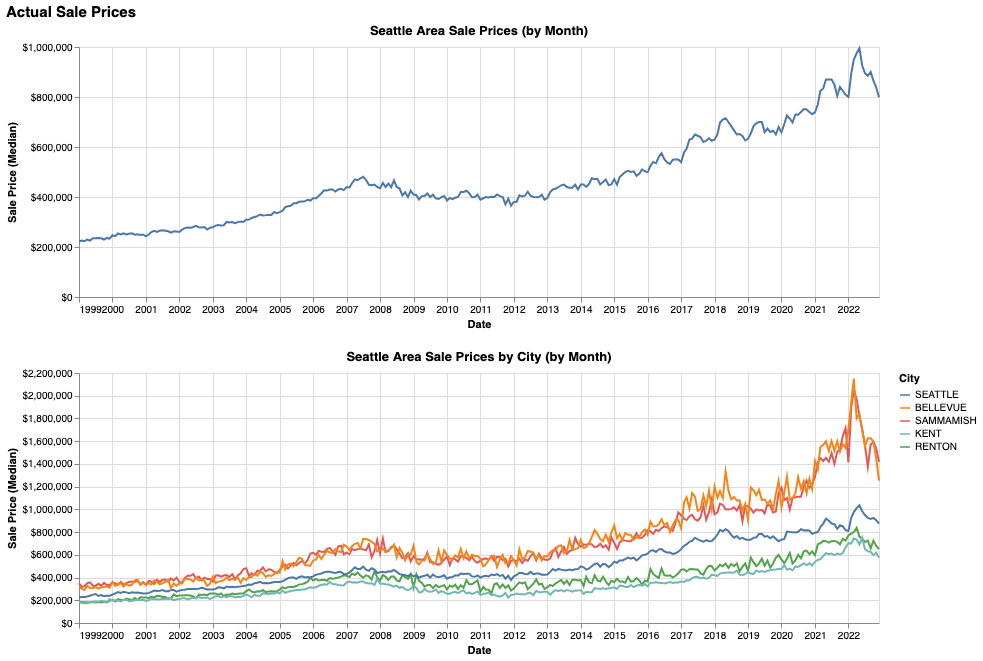

In [25]:
def get_saleprices(df, region=None):
    df = df.copy()
    df["sale_date_yyyymm"] = df["sale_date"].astype(str).str[:-3].str.replace("-", "")
    df["sale_decade"] = df["sale_date"].apply(lambda x: "{}'s".format(x.year - (x.year % 10)))
    df["sale_year"] = df["sale_date"].dt.year
    df["sale_month"] = df["sale_date"].dt.month
    df["sale_week"] = df["sale_date"].dt.isocalendar().week
    df["sale_day"] = df["sale_date"].dt.day

    select_cols = ["sale_price", "sale_date_yyyymm", "sale_month", "sale_year"]
    select_cols += [region] if region is not None else []
    groupby_cols = ["sale_month", "sale_year"] + ([region] if region is not None else [])

    df_saleprices = df[select_cols].copy()
    df_saleprices = df_saleprices.groupby(groupby_cols)
    df_saleprices = df_saleprices["sale_price"].median().reset_index()
    df_saleprices["sale_date"] = df_saleprices.apply(lambda x: "{}-{}".format(
        str(int(x["sale_year"])), str(int(x["sale_month"])).zfill(2)
    ), axis=1)
    df_saleprices = df_saleprices.sort_values("sale_date").reset_index()

    if region is None:
        df_saleprices["sale_price_diff"] = (
            df_saleprices["sale_price"] # / df_saleprices.iloc[0]["sale_price"]
        )
    else:
        df_saleprices["sale_price_diff"] = (
            df_saleprices
            .groupby(region)
            .apply(
                lambda x: x["sale_price"] # / x.iloc[0]["sale_price"]
            )
            .droplevel(0)
            .sort_index()
        )
        top_regions = df[region].value_counts().index[:5]
        df_saleprices = df_saleprices[df_saleprices[region].isin(top_regions)]

    return df_saleprices


def plot_saleprices(df):
    source = get_saleprices(df)
    chart = alt.Chart(source).mark_line().encode(
        x=alt.X("sale_date:T", axis=alt.Axis(format="%Y", labelAngle=0, title="Date")),
        y=alt.Y("sale_price_diff", axis=alt.Axis(format="$,f"), title="Sale Price (Median)"),
    ).properties(
        title="Seattle Area Sale Prices (by Month)",
        height=250,
        width=800,
    )
    return chart


def plot_saleprices_by_city(df):
    source = get_saleprices(df, region="city")
    chart = alt.Chart(source).mark_line().encode(
        x=alt.X("sale_date:T", axis=alt.Axis(format="%Y", labelAngle=0, title="Date")),
        y=alt.Y("sale_price_diff", axis=alt.Axis(format="$,f"), title="Sale Price (Median)"),
        color=alt.Color("city", sort=list(df["city"].value_counts().index), title="City"),
    ).properties(
        title="Seattle Area Sale Prices by City (by Month)",
        height=250,
        width=800,
    )
    return chart


chart = alt.vconcat(
    plot_saleprices(df),
    plot_saleprices_by_city(df.query("city != 'KING COUNTY'")),
).resolve_scale(
    color="independent",
).properties(
    title=alt.TitleParams("Actual Sale Prices", fontSize=15),
)
chart.display()

In [26]:
def plot_index2(
    df,
    x_col,
    y_col,
    region_col,
    x_title,
    y_title,
    region_title,
    region_sort=None,
    y_col_low=None,
    y_col_high=None,
    return_errorbars=False,
):
    source = df.copy()

    if region_sort is None:
        region_sort = region_col

    tooltip = [
        alt.Tooltip('RegionName:N', title='Region Name'),
        alt.Tooltip('RegionID:N', title='Region ID'),
        alt.Tooltip(f'{x_col}:T', title='Date'),
        alt.Tooltip(f'{y_col}:Q'),
    ]

    if y_col_low is not None:
        tooltip += [alt.Tooltip(y_col_low)]
    if y_col_high is not None:
        tooltip += [alt.Tooltip(y_col_high)]

    chart = alt.Chart(source).mark_line(opacity=1).encode(
        x=alt.X(f'{x_col}:T', axis=alt.Axis(format='%Y-%m', labelAngle=-45, title=x_title)),
        y=alt.Y(f'{y_col}:Q', title=y_title),
        color=alt.Color(
            f'{region_col}:N',
            sort=alt.EncodingSortField(field=region_sort),
            title=region_title,
        ),
        tooltip=tooltip,
    ).properties(
        height=300,
        width=800,
    )

    if return_errorbars:
        errorbars = alt.Chart(source).mark_errorband(opacity=0.25).encode(
            x=x_col,
            y=alt.Y(f'{y_col_low}:Q', title=''),
            y2=alt.Y2(f'{y_col_high}:Q', title=''),
            color=alt.Color(
                f'{region_col}:N',
                legend=None,
                sort=alt.EncodingSortField(field=region_sort),
            ),
            tooltip=tooltip,
        )

    return (chart, errorbars) if return_errorbars else chart## Plots


def get_zhvi_indices(zhvi_indices, min_date, max_date):
    df_zhvi = pd.read_csv("../data/County_zhvi_uc_sfrcondo_tier_0.33_0.67_sm_sa_month.csv")

    df_zhvi = (
        df_zhvi
        .melt(
            id_vars=[
                'RegionID', 'SizeRank', 'RegionName', 'RegionType', 'StateName',
                'State', 'Metro', 'StateCodeFIPS', 'MunicipalCodeFIPS',
            ],
            var_name='date',
            value_name='value',
        )
        .assign(date=lambda x: pd.to_datetime(x['date'].str[:7] + '-01'))
        .assign(RegionID=lambda x: x['RegionID'].replace({v: k for k, v in zhvi_indices.items()}))
        .query(f'RegionID == {list(zhvi_indices.keys())}')
        .query(f'date >= @min_date')
        .query(f'date <= @max_date')
        .sort_values(['RegionID', 'date'])
        .reset_index(drop=True)
    )

    return df_zhvi


def zhvi_index(x):
    x = x.sort_values('date').reset_index(drop=True)
    x['value'] = x['value'] * (1. / x['value'][0])
    return x


def zhvi_index_diff(x):
    x = zhvi_index(x)
    x['value'] = x['value'].diff() / x['value']
    return x


zhvi_indices  = {
    "King County": 207,
    "Pierce County": 1322,
    "Snohomish County": 2847,
}
#df_zhvi = get_zhvi_indices(zhvi_indices, min_train_date, max_train_date)
df_zhvi = get_zhvi_indices(zhvi_indices, '2000-01-01', '2023-01-01')
df_zhvi = (
    df_zhvi
    .groupby(['RegionID'])
    .apply(lambda x: zhvi_index(x))
    .reset_index(drop=True)
)
df_zhvi_diff = (
    df_zhvi
    .groupby(['RegionID'])
    .apply(lambda x: zhvi_index_diff(x))
    .reset_index(drop=True)
)

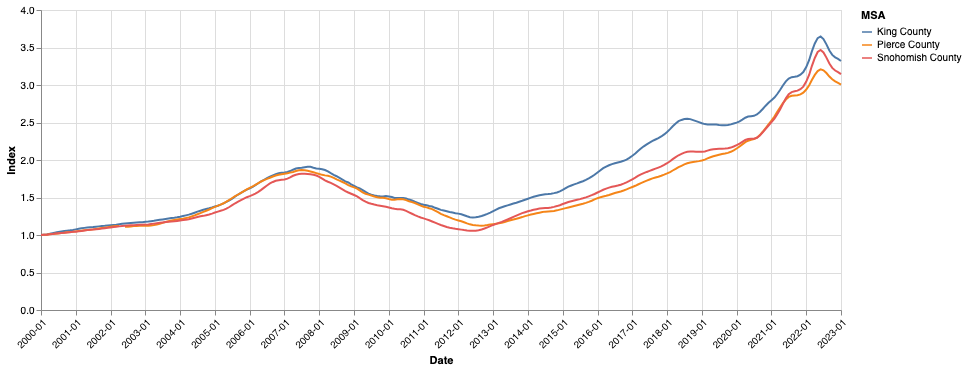

In [27]:
chart_zhvi = plot_index2(
    df_zhvi,
    'date',
    'value',
    'RegionName',
    'Date',
    'Index',
    'MSA',
    region_sort='RegionID',
    return_errorbars=False,
)
chart_zhvi.display()